In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
import pickle

# Open the file for reading
with open('/Volumes/WDSN570/df_feature_clean.pkl', 'rb') as f:
    # Load the object from the file
    data = pickle.load(f)

    

In [3]:
dates = data['date'].drop_duplicates().values
months = ['20170300', '20170400', '20170500', '20170600', '20170700', '20170800', '20170900', '20171000', '20171100', '20171200', 
          '20180100', '20180200', '20180300', '20180400', '20180500', '20180600', '20180700', '20180800', '20180900', '20181000', '20181100', '20181200', 
          '20190100', '20190200', '20190300', '20190400', '20190500', '20190600', '20190700', '20190800', '20190900', '20191000', '20191100', '20191200', 
          '20200100', '20200200', '20200300', '20200400', '20200500', '20200600', '20200700', '20200800', '20200900', '20201000', '20201100', '20201200', 
          '20210100', '20210200', '20210300', '20210400']
features = ['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5',
       'alpha6', 'alpha7', 'alpha8', 'alpha9', 'alpha12', 'alpha14', 'alpha15',
       'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20', 'alpha27',
       'alpha28', 'alpha29', 'alpha32', 'alpha33', 'alpha35', 'alpha36',
       'alpha38', 'alpha39', 'alpha40', 'alpha43', 'alpha44', 'alpha45',
       'alpha46', 'alpha47', 'alpha48', 'alpha52', 'alpha53', 'alpha54',
       'alpha60', 'alpha61', 'alpha62', 'alpha63', 'alpha64', 'alpha65',
       'alpha67', 'alpha68']


In [4]:
data['alpha'] = 0
for month_index in range(12, len(months)-1):
    train_X = data[(data['date']>=months[month_index-12]) & (data['date']<months[month_index])][features]
    train_y = data[(data['date']>=months[month_index-12]) & (data['date']<months[month_index])]['ret']
    test_X = data[(data['date']>=months[month_index]) & (data['date']<months[month_index+1])][features]
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(train_X, train_y)
    y_pred = xgb_model.predict(test_X)
    data.loc[(data['date']>=months[month_index]) & (data['date']<months[month_index+1]), 'alpha'] = y_pred



In [5]:
imp_data = data[data['date']>='20180300'][['date', 'ticker', 'alpha', 'ret']]
ticker_intervals = ['000001', '002101', '002648', '300325', '600235', '600882', '603999']
imp_data = imp_data.sort_values(by=['date', 'ticker'])

In [6]:
ret_df = imp_data.pivot(index='date', columns='ticker', values='ret').fillna(0).stack().reset_index().rename(columns={0: 'ret'})
alpha_df = imp_data.pivot(index='date', columns='ticker', values='alpha').fillna(0).stack().reset_index().rename(columns={0: 'alpha'})
data_df = pd.merge(ret_df, alpha_df, on=['date', 'ticker'])

In [7]:
data_df['market'] = 0
for i in ticker_intervals[1:]:
    data_df.loc[data_df['ticker']>i, 'market'] += 1
data_df['day'] = data_df.index // 3045
data_df['no_out'] = data_df.index % 3045
data_df['no_in'] = data_df['no_out'] - 500 * data_df['market']

In [8]:
res = data_df.groupby('ticker').apply(lambda x: x[['ret', 'alpha']].rolling(60, 20).corr().reset_index()[::2]['alpha'].fillna(0))
data_df['coef'] = res.T.stack().reset_index()[0].values

data_df['signal'] = np.sign(data_df['alpha'])
data_df['signal'] = (data_df['signal'] + data_df['signal']**2)/2

data_df['exp_coef_tmp'] = data_df['signal'] * data_df['ret']
data_df['exp_coef'] = data_df.groupby('ticker').apply(lambda x: x[['exp_coef_tmp']].rolling(60, 20).mean().fillna(0)).values
# data_df['exp_coef_var'] = data_df.groupby('ticker').apply(lambda x: x[['exp_coef_tmp']].rolling(60, 20).var().fillna(0)).values
data_df.drop(columns=['exp_coef_tmp'], inplace=True)

In [9]:
data_df

,date,ticker,ret,alpha,market,day,no_out,no_in,coef,signal,exp_coef
0,20180301,000001,0.000839,0.001363,0,0,0,0,0.000000,1.0,0.000000
1,20180301,000002,0.015313,0.000666,0,0,1,1,0.000000,1.0,0.000000
2,20180301,000004,0.020163,-0.002913,0,0,2,2,0.000000,0.0,0.000000
3,20180301,000005,0.005236,0.000497,0,0,3,3,0.000000,1.0,0.000000
4,20180301,000006,0.000000,0.000000,0,0,4,4,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2280700,20210329,603993,0.009381,0.001678,5,748,3040,540,-0.046969,1.0,-0.003800
2280701,20210329,603996,-0.052288,-0.002704,5,748,3041,541,0.135366,0.0,0.004439
2280702,20210329,603997,0.014797,-0.000639,5,748,3042,542,0.090515,0.0,0.000414
2280703,20210329,603998,-0.016822,-0.000759,5,748,3043,543,0.087338,0.0,-0.000143


In [10]:
cov_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for mkt in range(6):
    for day in range(749):
        tmp_data = data_df[(data_df['day']==day) & (data_df['market']==mkt)][['ret', 'exp_coef', 'signal']].copy()
        dim = 500 if mkt != 5 else 545
        vec1 = (tmp_data['ret'] * tmp_data['signal']).values.reshape(-1, 1)
        vec2 = tmp_data['exp_coef'].values.reshape(-1, 1)
        cov = vec1 @ vec1.T - vec2 @ vec2.T
        cov_dict[mkt].append(cov)



In [11]:
cov_est_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for mkt in range(6):
    cov = np.mean(cov_dict[mkt][:60], axis=0)
    cov_est_dict[mkt].append(cov)
    for day in range(61, 749):
        cov = cov + cov_dict[mkt][day]/60 - cov_dict[mkt][day-60]/60
        cov_est_dict[mkt].append(cov)

In [12]:
cov_est_dict_2 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for mkt in range(6):
    for day in range(60, 749):
        series = data_df[(data_df['day']<=day) & (data_df['day']>day-60) & (data_df['market']==mkt)]['exp_coef'].values.reshape((-1, 60))
        cov_est_dict_2[mkt].append(np.cov(series))

In [13]:
ret_est_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for mkt in range(6):
    for day in range(60, 749):
        tmp_data = data_df[(data_df['day']==day) & (data_df['market']==mkt)][['exp_coef']].copy()
        ret_est = tmp_data['exp_coef'].values.reshape(-1)
        ret_est_dict[mkt].append(ret_est)

In [14]:
from qpsolvers import solve_qp
from cvxopt import matrix, solvers, div
def solve_sub(V, r):
    n = len(r)
    P = V
    q = np.zeros(n)
    G = np.vstack([r, -np.eye(n)])
    h = np.array([1.0]+[-1e-23]*n).reshape(-1,)
    # A = r
    # b = np.array([1.0])

    x = solve_qp(P=P, q=q, G=G, h=h, solver="cvxopt")
    if x is not None:
        return x, np.dot(x, r), np.dot(x, V @ x)
    else:
        print("No solution",end=' ')
        return np.zeros(n), 0, 0

def solve_final(Vs, rs, gamma_1, gamma_2, x1):
    Vs, rs, x1 = matrix(Vs), matrix(rs), matrix(x1)
    def objective(x=None, z=None):
        if x == None:
            return 0, matrix(1.0, (len(rs), 1))#, matrix(0.0, (len(rs), len(rs)))
        f = - x.T * rs + matrix(np.sqrt(x.T * Vs * x) * gamma_1) + matrix(np.sqrt((x-x1).T*(x-x1)) * gamma_2)
        Df = - rs + Vs * x / matrix(np.sqrt(x.T * Vs * x) / gamma_1) + (x-x1) / matrix(np.sqrt((x-x1).T*(x-x1)) / gamma_2) 
        if z == None:
            return f, Df.T
        H = Vs / matrix(np.sqrt(x.T * Vs * x) / gamma_1) - x.T * Vs.T * Vs * x / matrix((x.T * Vs * x)**(3/2) / gamma_1) 
        H += matrix(np.eye(len(rs))) / matrix(np.sqrt((x-x1).T*(x-x1)) / gamma_2) - (x-x1)*(x-x1).T / matrix(((x-x1).T*(x-x1))**(3/2) / gamma_2)
        return f, Df.T, H
    A = matrix(1.0, (1, len(rs)))
    b = matrix(1.0, (1, 1))
    G = -matrix(np.eye(len(rs))*1.0)
    h = -matrix(np.ones(len(rs))*0.01)
    sol = solvers.cp(objective, A=A, b=b, G=G, h=h)
    return sol

In [15]:
res_inside = {}
res_outside = {}
for day in range(60, 749):
    sols = [solve_sub(cov_est_dict_2[mkt][day-60], ret_est_dict[mkt][day-60]) for mkt in range(6)]
    # xs = np.array([sol[0] for sol in sols]).reshape(-1)
    xs = np.concatenate([sol[0] for sol in sols]).reshape(-1)
    rs = np.array([sol[1]/np.sum(sol[0]) if np.sum(sol[0])>0 else 0 for sol in sols])
    Vs = np.diag([sol[2]/np.sum(sol[0])**2 if np.sum(sol[0])>0 else 0 for sol in sols])
    res_inside[day] = [xs, rs, Vs]

    gamma_1 = 1e-4
    gamma_2 = 2e-4
    x1 = np.array([1.,0.,0.,0.,0.,0.,]) if day == 60 else res_outside[day-1]
    if max(rs) > 0:
        sol_ = solve_final(Vs, rs, gamma_1, gamma_2, x1)['x']
        x = np.array(sol_).reshape(-1)
        res_outside[day] = x
    else:
        x = x1
        res_outside[day] = x
    # print(rs.shape, x.shape, Vs.shape, x1.shape)
    # print(rs.T@x, np.sqrt(x.T@Vs@x), np.sqrt((x-x1).T@(x-x1)))
    # print(rs)
    # print(day, rs@x, rs, x)

In [18]:
compare_ret = pd.DataFrame(columns=['outside', 'mean', 'max', 'mmax'])
rm1, rm2, rm3 = 0, 0, 0
for i in range(61, 749):
    if np.max(res_inside[i-1][1]) < 0:
        compare_ret.loc[i, 'outside'] = 0
        compare_ret.loc[i, 'mean'] = 0
        compare_ret.loc[i, 'max'] = 0
        compare_ret.loc[i, 'mmax'] = 0
    else:
        compare_ret.loc[i, 'outside'] = res_outside[i-1] @ res_inside[i][1] - np.sqrt((res_outside[i-1] - rm1).T @ (res_outside[i-1] - rm1)) * gamma_2
        rm1 = res_outside[i-1]
        compare_ret.loc[i, 'mean'] = np.mean(res_inside[i][1])
        compare_ret.loc[i, 'max'] = res_inside[i][1][np.argmax(res_inside[i-1][1])]
        rm_tmp = np.zeros(6)
        rm_tmp[np.argmax(res_inside[i-1][1])] = 1
        compare_ret.loc[i, 'max'] -= np.sqrt((rm_tmp - rm2).T @ (rm_tmp - rm2)) * gamma_2
        rm2 = rm_tmp
        compare_ret.loc[i, 'mmax'] = res_inside[i][1][np.argmax(res_inside[i][1])] 
        rm_tmp = np.zeros(6)
        rm_tmp[np.argmax(res_inside[i][1])] = 1
        compare_ret.loc[i, 'mmax'] -= np.sqrt((rm_tmp - rm3).T @ (rm_tmp - rm3)) * gamma_2
        rm3 = rm_tmp



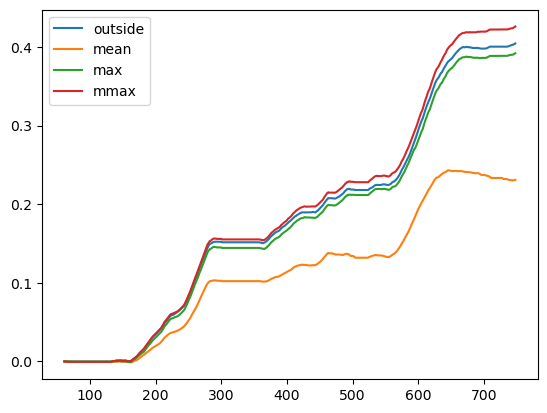

In [30]:
compare_ret.cumsum().plot()
import matplotlib.pyplot as plt
plt.savefig('compare_ret.png')

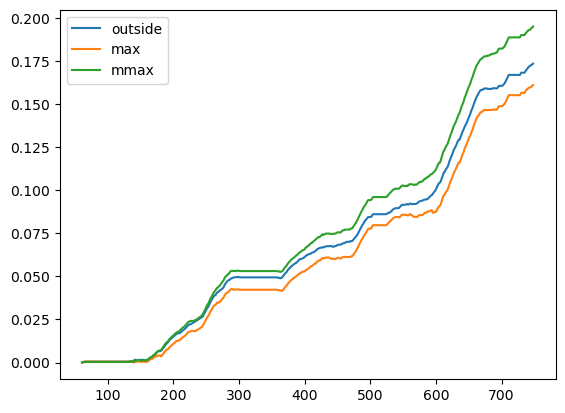

In [31]:
tmp_compare_ret = compare_ret.copy()
tmp_compare_ret['outside'] -= tmp_compare_ret['mean']
tmp_compare_ret['max'] -= tmp_compare_ret['mean']
tmp_compare_ret['mmax'] -= tmp_compare_ret['mean']
tmp_compare_ret[['outside', 'max', 'mmax']].cumsum().plot()
plt.savefig('compare_ret_diff.png')

In [25]:
compare_ret_v = pd.DataFrame(columns=['outside', 'mean', 'max', 'mmax'])
rm1, rm2, rm3 = np.zeros(6), np.zeros(6), np.zeros(6)
for i in range(61, 749):
    if np.max(res_inside[i-1][1]) < 0:
        compare_ret_v.loc[i, 'outside'] = 0
        compare_ret_v.loc[i, 'mean'] = 0
        compare_ret_v.loc[i, 'max'] = 0
        compare_ret_v.loc[i, 'mmax'] = 0
    else:
        compare_ret_v.loc[i, 'outside'] = res_outside[i-1] @ res_inside[i][1] - np.sqrt((res_outside[i-1] - rm1).T @ (res_outside[i-1] - rm1)) * gamma_2 
        compare_ret_v.loc[i, 'outside'] -= gamma_1 * np.sqrt(res_outside[i-1] @ res_inside[i][2] @ res_outside[i-1])*100
        rm1 = res_outside[i-1]
        compare_ret_v.loc[i, 'mean'] = np.mean(res_inside[i][1])
        compare_ret_v.loc[i, 'max'] = res_inside[i][1][np.argmax(res_inside[i-1][1])]
        rm_tmp = np.zeros(6)
        rm_tmp[np.argmax(res_inside[i-1][1])] = 1
        compare_ret_v.loc[i, 'max'] -= np.sqrt((rm_tmp - rm2).T @ (rm_tmp - rm2)) * gamma_2 + gamma_1 * np.sqrt(res_inside[i][2][np.argmax(res_inside[i-1][1]), np.argmax(res_inside[i-1][1])])*100
        rm2 = rm_tmp
        compare_ret_v.loc[i, 'mmax'] = res_inside[i][1][np.argmax(res_inside[i][1])] 
        rm_tmp = np.zeros(6)
        rm_tmp[np.argmax(res_inside[i][1])] = 1
        compare_ret_v.loc[i, 'mmax'] -= np.sqrt((rm_tmp - rm3).T @ (rm_tmp - rm3)) * gamma_2 + gamma_1 * np.sqrt(res_inside[i][2][np.argmax(res_inside[i][1]), np.argmax(res_inside[i][1])])*100
        rm3 = rm_tmp



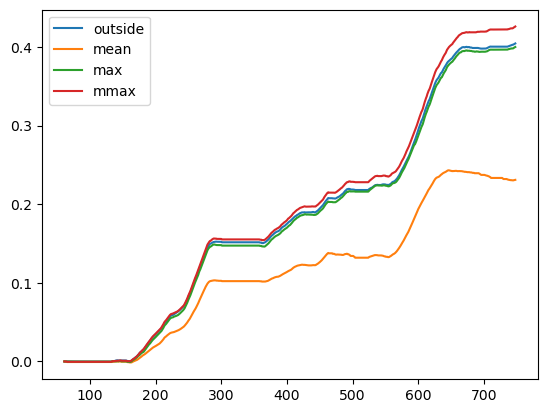

In [32]:
compare_ret_v.cumsum().plot()
plt.savefig('compare_ret_v_100.png')